# モーター制御のシミュレーション


## 目的

賢いモータードライバICを使えば指示だけ出せば、電流などを計測しつつ適切な制御を簡単確実に行ってくれる。

ここでわざわざ単純なスイッチのみのドライバICを使ってFPGA側でモーター制御を試みようというのは、ドライバICの知りえない電流値以外の要素を制御に利用したらどうなるか？ という興味本位の実験に他ならない。
拙作のLUT-Netは超高速なニューラルネットであり、他センサーの情報を使って通常ドライバICにお任せしてしまう高周波数領域に適用できる可能性がある。もし電流計測することなく電流を見ているドライバと同等の制御ができたりすると面白い。ダイレクトドライブをする限り、モーターコイルの電流値はそのまま物理現象として現れるはずなので例えば、加速度センサやイメージセンサなどの情報を用いてシンプルな制御で脱調の検知や、マイクロステップ部分の制御など、電流計測が必要な制御が代替できないかという話である。

と、いうことで基本的な部分を作り始めてみたのですが、これが意外に難しい。専用ドライバICはすごくよくできている。
まずコンセプトの実験ができる程度の簡素なものでいいので頑張りたい。



## やりたい制御

まずは一定周期毎にPWM幅を変えてモーターの制御状態を変える。その際に、目標位置を指定した場合に指定加速度をなるべく超えないように目的位置に移動させるという事がしたい。

その際
$$
x = vt + \frac{1}{2}at^2
$$

という連続的な物理モデルではなく

$$
\begin{eqnarray*}
x_t &=& x_{t-1} + v_{t-1} \\
v_t &=& v_{t-1} + a_{t-1}
\end{eqnarray*}
$$

という漸化式を元に、加減速の制御変換点を求める


## 計算

移動開始時の最大速度を $v$、加速度を $a$ とする。停止まで $n$ ステップを要するとして、移動する長さ $l$ は、等差数列の和であるから

$$
l = \frac{n(n+1)a}{2}
$$

ここで $n$ は
$$
n = \frac{v}{a}
$$

であるから、停止するための条件が

$$
\begin{eqnarray}
l = \frac{\frac{v}{a}(\frac{v}{a}+1)a}{2} \\
2l = \frac{v^2}{a} + v \\
v^2 + av - 2al = 0 \\
v = \frac{-a \pm \sqrt{a^2 + 8ab}}{2}
\end{eqnarray}
$$

として得られる

## 実装
計算過程で平方根などがあり量子化誤差が吸収できないので、近傍に移動したら最大加速要件を緩和して止める(インチキ)

In [1]:
import math
import matplotlib.pyplot as plt

In [2]:
def calc_len_sim(v, a):
    '''繰り返しシミュレーションで停止までの移動量(制動距離)を求める
    Args:
        v(int): 速度
        a(int): 加速度
    Returns:
        int: 移動距離
        
    '''
    l = 0
    while v > 0:
        l += v
        v -= a
    return l


def calc_limit_v_sim(l, a):
    '''繰り返しシミュレーションで停止可能な最大速度を求める
    Args:
        l(int): 距離
        a(int): 加速度
    Returns:
        int: 最大速度
        
    '''
    v = 0
    while calc_len_sim(v, a) < l:
        v += 1
    return v

def calc_limit_v_physics(l, a):
    '''物理学で停止可能な最大速度を求める
    Args:
        l(int): 距離
        a(int): 加速度
    Returns:
        int: 最大速度
        
    '''    
    v = int(math.sqrt(2 * a * l))
    return v

def calc_limit_v_recurrence(l, a):
    '''漸化式で停止可能な最大速度を求める
    Args:
        l(int): 距離
        a(int): 加速度
    Returns:
        int: 最大速度
        
    '''
    v = int((-a + int(math.sqrt(a*(a + 8*l))))//2)
    return v

def calc_limit_v(l, a):
    '''デフォルトで漸化式を採用'''
    return calc_limit_v_recurrence(l, a)

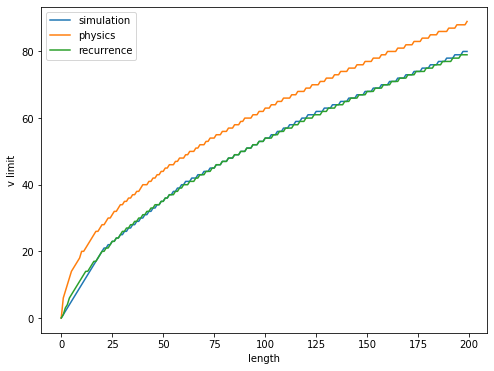

In [3]:
# モデルの差や量子化誤差を俯瞰してみる
a = 20
list_sim = []
list_phy = []
list_rec = []
for i in range(200):
    list_sim.append(calc_limit_v_sim(i, a))
    list_phy.append(calc_limit_v_physics(i, a))
    list_rec.append(calc_limit_v_recurrence(i, a))

plt.figure(figsize=(8, 6))
plt.plot(list_sim, label='simulation')
plt.plot(list_phy, label='physics')
plt.plot(list_rec, label='recurrence')
plt.xlabel('length')
plt.ylabel('v limit')
plt.legend()
plt.savefig("model_difference.png")

In [19]:
class motor_model:
    '''簡単なモデルを作成'''
    
    def __init__(self):
        self.target_en  = False  # 目標位置は存在するか
        self.target_x   = 0       # 目標位置
        
        self.cur_x      = 0       # 現在の位置
        self.cur_v      = 0       # 現在の速度
        self.cur_a      = 0       # 現在の加速度
        
        self.max_v      = 20      # 最大速度
        self.max_a      = 3       # 最大加速度
        self.max_a_near = 4       # 近距離での最大加速度(誤差吸収用)
        
        self.log_x     = []       # 位置のログ
        self.log_v     = []       # 速度のログ
        self.log_a     = []       # 加速度のログ

    def clear_log(self):
        self.log_pos   = []
        self.log_speed = []
        self.log_acc   = []
    
    def step(self):
        max_a = self.max_a
        
        if self.target_en:
            # 目標位置が有効なら加速制御
            d     = self.target_x - self.cur_x
            lim_v = calc_limit_v(d, self.max_a)
            self.cur_a = lim_v - self.cur_v
            print('d:%d lim_v:%d a:%d' %(d, lim_v, self.cur_a))
            
            # 近傍なら閾値を変えて丸める(インチキ)
            if d <= self.max_a and d >= -self.max_a:
                self.cur_a = d - self.cur_v 
                max_a = self.max_a_near
        
        # 上限でクリップしてステップを進める
        self.cur_a = min(max(self.cur_a, -max_a), +max_a)
        self.cur_v += self.cur_a
        self.cur_v = min(max(self.cur_v, -self.max_v), +self.max_v)
        self.cur_x += self.cur_v
        
        self.log_x.append(self.cur_x)
        self.log_v.append(self.cur_v)
        self.log_a.append(self.cur_a)
        
        return self.cur_x
    
    def set_target_x(self, target_x, target_en=True):
        self.target_x  = target_x
        self.target_en = target_en

    def set_max_a(self, max_a, max_a_near=-1):
        self.max_a = max_a
        if max_a_near < 0:
            max_a_near = max_a + ((max_a + 1) // 2)  # 暫定で1.5倍
        self.max_a_near = max_a_near
    
    def set_max_v(self, max_v):
        self.max_v = max_v

    def set_cur_v(self, a):
        self.cur_a = a 
        
    def set_cur_a(self, a):
        self.cur_a = a 
    
    def get_cur_x(self):
        return self.cur_x

    def get_cur_v(self):
        return self.cur_v
        
    def get_cur_a(self):
        return self.cur_a
    
    def get_log_x(self):
        return self.log_x

    def get_log_v(self):
        return self.log_v
        
    def get_log_a(self):
        return self.log_a

In [20]:
def print_status(motor):
    print('x:%d v:%d a:%d' % (motor.get_cur_x(), motor.get_cur_v(), motor.get_cur_a()))

max_v : 1310720
max_a : 65536
x:0 v:0 a:0
x:0 v:0 a:0
x:0 v:0 a:0
x:0 v:0 a:0
x:0 v:0 a:0
[1]
d:65536000 lim_v:2898274 a:2898274
x:65536 v:65536 a:65536
[2]
d:65470464 lim_v:2896808 a:2831272
x:196608 v:131072 a:65536
[3]
d:65339392 lim_v:2893874 a:2762802
x:393216 v:196608 a:65536
[4]
d:65142784 lim_v:2889468 a:2692860
x:655360 v:262144 a:65536
[5]
d:64880640 lim_v:2883584 a:2621440
x:983040 v:327680 a:65536
[6]
d:64552960 lim_v:2876211 a:2548531
x:1376256 v:393216 a:65536
[7]
d:64159744 lim_v:2867338 a:2474122
x:1835008 v:458752 a:65536
[8]
d:63700992 lim_v:2856953 a:2398201
x:2359296 v:524288 a:65536
[9]
d:63176704 lim_v:2845038 a:2320750
x:2949120 v:589824 a:65536
[10]
d:62586880 lim_v:2831575 a:2241751
x:3604480 v:655360 a:65536
[11]
d:61931520 lim_v:2816541 a:2161181
x:4325376 v:720896 a:65536
[12]
d:61210624 lim_v:2799911 a:2079015
x:5111808 v:786432 a:65536
[13]
d:60424192 lim_v:2781657 a:1995225
x:5963776 v:851968 a:65536
[14]
d:59572224 lim_v:2761748 a:1909780
x:6881280 v:917

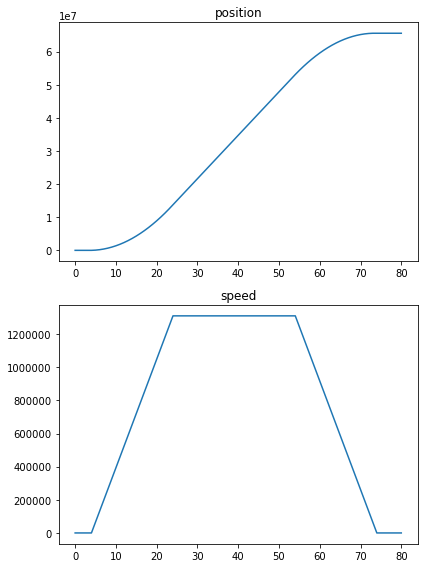

In [25]:
# 適当に移動してみる
motor = motor_model()
motor.set_max_v(20*65536)
motor.set_max_a(1*65536)

print('max_v :', motor.max_v)
print('max_a :', motor.max_a)

pos_list =[]
spd_list =[]

for i in range(5):
    pos_list.append(motor.step())
    print_status(motor)

motor.set_target_x(1000*65536)

t = 1
for i in range(5):
    print('[%d]' % t)
    pos_list.append(motor.step())
    t+=1
    print_status(motor)

while motor.get_cur_v() != 0 or motor.get_cur_a() != 0:
    print('[%d]' % t)
    pos_list.append(motor.step())
    t+=1
    print_status(motor)

for i in range(5):
    pos_list.append(motor.step())

plt.figure(figsize=(6, 8))
plt.subplot(211)
plt.title("position")
plt.plot(motor.get_log_x())
plt.subplot(212)
plt.title("speed")
plt.plot(motor.get_log_v())
plt.tight_layout()
plt.savefig('graph0.png')
plt.show()

<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 100 1 13 13
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 99 1 13 13
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 97 1 13 13
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 94 1 13 13
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 90 1 12 12
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 85 1 12 12
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 79 1 12 12
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 72 1 11 11
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 64 1 10 10
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 55 1 10 10
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 45 1 9 9
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
calc_limit_v 36 1 8 8
<class 'int'> <class 'int'>
<class 'int'> <

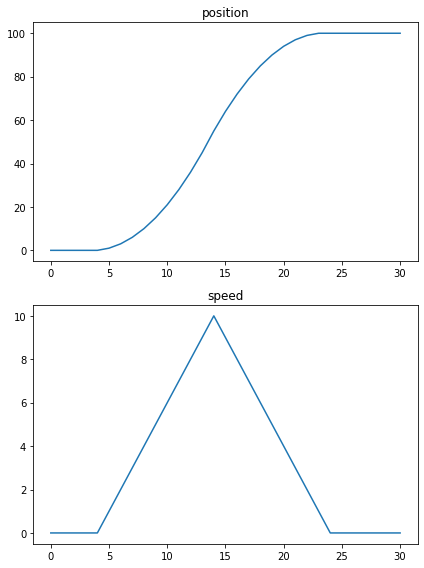

In [10]:
# 最大速度に達する前に減速しないといけないパターン
motor = motor_model()
motor.set_max_v(20)
motor.set_max_a(1)

pos_list =[]
spd_list =[]

for i in range(5):
    pos_list.append(motor.step())

motor.set_target_x(100)

for i in range(5):
    pos_list.append(motor.step())

while motor.get_cur_v() != 0 or motor.get_cur_a() != 0:
    pos_list.append(motor.step())

for i in range(5):
    pos_list.append(motor.step())

    
plt.figure(figsize=(6, 8))
plt.subplot(211)
plt.title("position")
plt.plot(motor.get_log_x())
plt.subplot(212)
plt.title("speed")
plt.plot(motor.get_log_v())
plt.tight_layout()
plt.savefig('graph1.png')
plt.show()